In [27]:
ver = 'linear_v20'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import time
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, SGDClassifier

from sklearn.feature_selection import RFE

import eli5

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
import os
print(os.listdir("../input"))

from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

RANDOM_STATE = 78



['test.csv', 'train.csv', 'sample_submission.csv']


**Load datasets**

In [28]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [29]:
train.shape, test.shape

((250, 302), (19750, 301))

In [30]:
train.describe()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.640000,0.023292,-0.026872,0.167404,0.001904,0.001588,-0.007304,0.032052,0.078412,-0.036920,0.035448,-0.005032,0.110248,0.019808,-0.001108,-0.016280,-0.039644,0.017260,-0.106856,0.036184,-0.043296,-0.110832,0.072680,0.017296,-0.030728,-0.128252,0.154736,0.083408,0.039552,-0.091784,0.054636,-0.048288,-0.017296,0.007708,-0.134460,0.093852,-0.020588,-0.002492,-0.141400,...,0.005780,-0.102304,-0.013796,0.089384,0.036368,0.016276,-0.069448,-0.113236,0.035696,0.034484,-0.066236,-0.057988,0.091556,-0.029896,0.115648,0.007372,0.033552,0.090524,0.001576,-0.007784,0.043184,0.082696,0.098476,0.055356,0.111708,-0.015688,0.035992,0.026452,-0.059152,0.077272,0.044652,0.126344,0.018436,-0.012092,-0.065720,-0.106112,0.046472,0.006452,0.009372,-0.128952
std,72.312977,0.480963,0.998354,1.009314,1.021709,1.011751,1.035411,0.955700,1.006657,0.939731,0.963688,1.019689,1.085089,1.036265,1.050041,1.024305,0.926789,0.955915,1.025655,1.012777,0.945099,1.055935,1.003178,1.039556,0.988482,0.945902,0.997026,0.997894,1.040371,0.922270,1.047282,1.041432,1.010971,0.992464,0.986350,1.015563,1.117898,0.958191,0.948855,1.042429,...,0.994761,1.094494,1.026025,0.963489,1.026373,1.008207,0.989451,1.002857,0.944743,1.023709,0.985451,0.951879,1.027877,0.966882,1.037173,1.004543,1.006219,1.037119,1.024067,1.056086,1.012516,1.068741,0.934163,0.988100,1.043230,1.010720,1.058982,0.896318,1.113760,0.972530,1.011416,0.972567,0.954229,0.960630,1.057414,1.038389,0.967661,0.998984,1.008099,0.971219
min,0.000000,0.000000,-2.319000,-2.931000,-2.477000,-2.359000,-2.566000,-2.845000,-2.976000,-3.444000,-2.768000,-2.361000,-3.302000,-2.851000,-2.681000,-2.596000,-3.275000,-3.512000,-2.476000,-3.619000,-2.428000,-3.229000,-3.024000,-2.775000,-2.962000,-2.490000,-3.107000,-2.943000,-2.933000,-2.942000,-2.957000,-2.911000,-2.568000,-2.649000,-3.031000,-2.913000,-3.265000,-2.372000,-3.037000,-3.340000,...,-2.512000,-2.873000,-2.549000,-2.721000,-2.578000,-2.239000,-3.046000,-2.755000,-2.507000,-3.369000,-2.448000,-2.771000,-2.903000,-2.522000,-2.759000,-2.915000,-2.618000,-3.623000,-2.673000,-3.229000,-2.537000,-2.748000,-2.850000,-2.577000,-2.973000,-2.709000,-3.605000,-2.357000,-2.904000,-2.734000,-2.804000,-2.443000,-2.757000,-2.466000,-3.287000,-3.072000,-2.634000,-2.776000,-3.211000,-3.500000
25%,62.250000,0.000000,-0.644750,-0.739750,-0.425250,-0.686500,-0.659000,-0.643750,-0.675000,-0.550750,-0.689500,-0.643500,-0.693500,-0.524000,-0.708500,-0.692000,-0.677000,-0.634500,-0.683500,-0.801500,-0.574250,-0.758000,-0.870500,-0.596000,-0.725750,-0.652000,-0.779500,-0.424250,-0.585750,-0.625000,-0.751250,-0.582500,-0.713500,-0.750000,-0.588000,-0.829000,-0.648500,-0.659750,-0.614000,-0.816750,...,-0.622750,-1.009250,-0.693250,-0.567750,-0.696500,-0.684000,-0.703750,-0.771250,-0.624500,-0.653000,-0.786750,-0.701000,-0.54

Text(0.5, 1.0, 'Target')

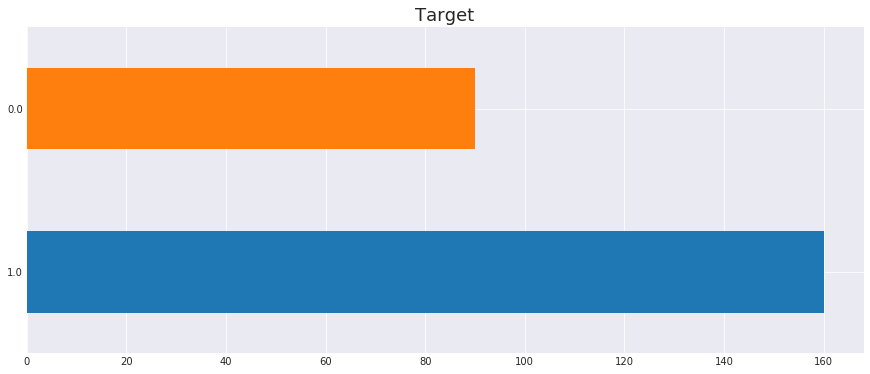

In [31]:
train['target'].value_counts().sort_index(ascending=False).plot(kind='barh', 
                                                                          figsize=(15,6))
plt.title('Target', fontsize=18)

**Data preparation**

In [32]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_tst = test.drop(['id'], axis=1)

In [33]:
sc0 = StandardScaler()
sc0.fit(X_train)
X_train = sc0.transform(X_train)
X_test = sc0.transform(X_tst)


In [34]:
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
repfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=RANDOM_STATE)
logreg0 = LogisticRegression(C=0.5, random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
lass0 = Lasso(alpha=0.031, tol=0.01, selection='random', random_state=RANDOM_STATE)
ridg0 = Ridge(alpha=20, fit_intercept=True, solver='auto', tol=0.0025, random_state=RANDOM_STATE)
sgd0 = SGDClassifier(eta0=1, max_iter=1000, tol=0.0001, random_state=RANDOM_STATE, loss='log')

**Fit simple logreg**

In [35]:
logreg0.fit(X_train, y_train)
sc = cross_val_score(logreg0, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.2s


0.7757291666666666


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


In [36]:
eli5.show_weights(logreg0, top=10)

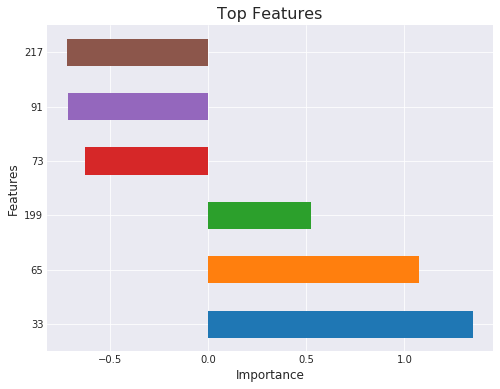

In [37]:
el_df =pd.Series(logreg0.coef_[0],index=train.drop(['id', 'target'], axis=1).columns)
el_df = el_df[(logreg0.coef_[0]<=-0.5) | (logreg0.coef_[0]>=0.5)].sort_values(ascending=False)
plt.figure(figsize=(8,6))
el_df.plot(kind='barh')
plt.xlabel("Importance",fontsize=12)
plt.ylabel("Features",fontsize=12)
plt.title("Top Features",fontsize=16)
plt.show()

**Hyperparameters search for logreg with *GridSearchCV***

In [38]:
param_lr = {'class_weight' : ['balanced', None], 
                'penalty' : ['l2','l1'],  
                'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
           }

In [ ]:
grid_lr = GridSearchCV(estimator = logreg0, param_grid = param_lr , scoring = 'roc_auc', verbose = 1, n_jobs = -1, cv=repfold)

grid_lr.fit(X_train,y_train)

print("Best Score:" + str(grid_lr.best_score_))
print("Best Parameters: " + str(grid_lr.best_params_))


In [ ]:
best_parameters_lr = grid_lr.best_params_
logreg = LogisticRegression(**best_parameters_lr)
logreg.fit(X_train,y_train)
sc = cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

selector_lr = RFE(logreg, 25, step=1)
selector_lr.fit(X_train,y_train)
sc = cross_val_score(selector_lr, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

**Hyperparameters search for logreg with *hyperopt***

In [39]:
def acc_model(params):
    clf = LogisticRegression(**params)
    return cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=repfold).mean()

In [40]:
space4lr = {'C': hp.uniform('C', .0001, 100.0), 
            'solver' : hp.choice('solver', ['liblinear']),
            'penalty' : hp.choice('penalty', ['l1', 'l2']),
            #'dual' : hp.choice('dual', [True, False]),
            #'fit_intercept': hp.choice('fit_intercept', ['True', 'False']),
            'class_weight': hp.choice('class_weight', ['balanced', None]),
            'max_iter': hp.choice('max_iter', [50000]),
            'random_state': 78, #hp.uniformint('random_state', 1, 100),
            #'n_jobs': -1
           }

best = 0
pr = []
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
        pr.append(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4lr, algo=tpe.suggest, max_evals=3000, trials=trials)
print ('best for logreg: ')
print (pr[-1])

new best:                                             
0.7386111111111111                                    
{'C': 88.24353361414632, 'class_weight': 'balanced', 'max_iter': 50000, 'penalty': 'l2', 'random_state': 78, 'solver': 'liblinear'}
new best:                                                                         
0.7613368055555554                                                                
{'C': 72.47812008319777, 'class_weight': 'balanced', 'max_iter': 50000, 'penalty': 'l1', 'random_state': 78, 'solver': 'liblinear'}
new best:                                                                         
0.7617881944444445                                                                
{'C': 74.827631786164, 'class_weight': None, 'max_iter': 50000, 'penalty': 'l1', 'random_state': 78, 'solver': 'liblinear'}
new best:                                                                         
0.7631597222222223                                                                
{'C'

KeyboardInterrupt: 

In [ ]:
print(pr[-1])
best = pr[-1]
logreg1 = LogisticRegression(**best)
logreg1.fit(X_train,y_train)
sc = cross_val_score(logreg1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

selector_lr1 = RFE(logreg1, 25, step=1)
selector_lr1.fit(X_train,y_train)
sc = cross_val_score(selector_lr1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

**Fit simple Lasso**

In [ ]:
lass0.fit(X_train, y_train)
sc = cross_val_score(lass0, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

In [ ]:
eli5.show_weights(lass0, top=10)

In [ ]:
el_df =pd.Series(lass0.coef_,index=train.drop(['id', 'target'], axis=1).columns)
el_df = el_df[(lass0.coef_<=-0.05) | (lass0.coef_>=0.05)].sort_values(ascending=False)
plt.figure(figsize=(8,6))
el_df.plot(kind='barh')
plt.xlabel("Importance",fontsize=12)
plt.ylabel("Features",fontsize=12)
plt.title("Top Features",fontsize=16)
plt.show()

**Hyperparameters search for Lasso with *GridSearchCV***

In [ ]:
param_lass = {
            'alpha' : [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]
        }

In [ ]:
grid_lass = GridSearchCV(estimator = lass0, param_grid = param_lass , scoring = 'roc_auc', verbose = 1, n_jobs = -1, cv=repfold)

grid_lass.fit(X_train,y_train)

print("Best Score:" + str(grid_lass.best_score_))
print("Best Parameters: " + str(grid_lass.best_params_))

In [ ]:
best_parameters_lass = grid_lass.best_params_
lass = Lasso(**best_parameters_lass)
lass.fit(X_train,y_train)
sc = cross_val_score(lass, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

selector_lass = RFE(lass, 5, step=1)
selector_lass.fit(X_train,y_train)
sc = cross_val_score(selector_lass, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

**Hyperparameters search for Lasso with *hyperopt***

In [ ]:
def acc_model(params):
    clf = Lasso(**params)
    return cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=repfold).mean()

In [ ]:
space4lass = {'alpha' : hp.uniform('alpha', .0001, 1),
            'tol'   : hp.uniform('tol', .0001, 1),
            'random_state': 78, #hp.uniformint('random_state', 1, 100),
            'max_iter': hp.choice('max_iter', [50000]),
             }

best = 0
pr = []
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
        pr.append(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4lass, algo=tpe.suggest, max_evals=3000, trials=trials)
print ('best for lasso: ')
print (pr[-1])

In [ ]:
print(pr[-1])
best = pr[-1]
lass1 = Lasso(**best)
lass1.fit(X_train,y_train)
sc = cross_val_score(lass1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

selector_lass1 = RFE(lass1, 5, step=1)
selector_lass1.fit(X_train,y_train)
sc = cross_val_score(selector_lass1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

**Fit simple Ridge**

In [ ]:
ridg0.fit(X_train, y_train)
sc = cross_val_score(ridg0, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

**Hyperparameters search for Ridge with *hyperopt***

In [ ]:
def acc_model(params):
    clf = Ridge(**params)
    return cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=repfold).mean()

In [ ]:
space4ri = {'alpha' : hp.uniform('alpha', 0.01, 1000),
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            'tol' : hp.uniform('tol', .0001, 1),
            'random_state' : 78, #hp.uniformint('random_state', 1, 100),
            'max_iter' : hp.choice('max_iter', [30000]),
            'solver' : hp.choice('solver', ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
             }

best = 0
pr = []
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
        pr.append(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4ri, algo=tpe.suggest, max_evals=3000, trials=trials)
print ('best for Ridge: ')
print (pr[-1])

In [ ]:
print(pr[-1])
best = pr[-1]
ridg1 = Ridge(**best)
ridg1.fit(X_train,y_train)
sc = cross_val_score(ridg1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

selector_ridg1 = RFE(ridg1, 5, step=1)
selector_ridg1.fit(X_train,y_train)
sc = cross_val_score(selector_ridg1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

**Fit simple SGDClassifier**

In [ ]:
sgd0.fit(X_train, y_train)
sc = cross_val_score(sgd0, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

In [ ]:
def acc_model(params):
    clf = SGDClassifier(**params)
    return cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=repfold).mean()

In [ ]:
space4sgd = {'loss': hp.choice('loss', ['log', 'modified_huber']),
             'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet']),
             'alpha' : hp.uniform('alpha', 0.01, 1000),
             'fit_intercept' : False, #hp.choice('fit_intercept', [True, False]),
             'tol' : hp.uniform('tol', .0001, 1),
             'random_state' : 78, #hp.uniformint('random_state', 1, 100),
             'max_iter' : hp.choice('max_iter', [30000]),
             'l1_ratio': hp.choice('l1_ratio', [0, 0.15, 0.5, 1.0]),
             'learning_rate': hp.choice('learning_rate', ['optimal', 'invscaling', 'adaptive']),
             'shuffle' : True,
             #'n_jobs': -1,
             'eta0': 1
             }

best = 0
pr = []
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
        pr.append(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4sgd, algo=tpe.suggest, max_evals=2000, trials=trials)
print ('best for SGDClassifier: ')
print (pr[-1])

In [ ]:
print(pr[-1])
best = pr[-1]
sgd1 = SGDClassifier(**best)
sgd1.fit(X_train,y_train)
sc = cross_val_score(sgd1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

selector_sgd1 = RFE(sgd1, 5, step=1)
selector_sgd1.fit(X_train,y_train)
sc = cross_val_score(selector_sgd1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

**Submission**

In [ ]:
def sub_pr(clf, filename):
    prediction_ = clf.predict_proba(X_test)[:,1]
    submission_ = pd.read_csv('../input/sample_submission.csv')
    submission_['target'] = prediction_
    submission_.to_csv(filename, index=False)
    print(submission_.head())
    
def sub_prp(clf, filename):
    prediction_ = clf.predict(X_test)
    submission_ = pd.read_csv('../input/sample_submission.csv')
    submission_['target'] = prediction_
    submission_.to_csv(filename, index=False)
    print(submission_.head())

In [ ]:

filename = 'subm_{}_{}_'.format(ver, datetime.now().strftime('%Y-%m-%d'))
filename

In [ ]:
sub_pr(logreg1, filename+'lr1.csv') # 0.848
sub_pr(selector_lr1, filename+'sel_lr1.csv') # 0.845

In [ ]:
sub_prp(lass1, filename+'lass1.csv')
sub_prp(selector_lass1, filename+'sel_lass1.csv')

In [ ]:
sub_pr(ridg1, filename+'ridg1.csv')
sub_pr(selector_ridg1, filename+'sel_ridg1.csv')

In [ ]:
sub_prp(sgd1, filename+'sgd1.csv')
sub_prp(selector_sgd1, filename+'sel_sgd1.csv')